# EDA

In [1]:
import numpy as np
import pandas as pd

In [131]:
from pathlib import Path
import glob
folder_path = Path(r"C:\Users\JohnOnGear\Desktop\DS and ML\Кагл проекты\Home Credit Default Risk\data")
data = {f.stem: pd.read_csv(f, encoding='latin1') for f in folder_path.glob("*.csv")}

pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', None)



# Создаем словарь признаков, для удобства чтения датасетов

In [3]:
from deep_translator import GoogleTranslator
translator = GoogleTranslator(source='auto', target='ru')

df_slovar = data['HomeCredit_columns_description']
slovar = {}
translation_cache = {}
for row in df_slovar.itertuples():
    table_name = row.Table
    column_name = row.Row.strip()
    description = row.Description

    if not isinstance(description, str):
        continue

    description = description.strip()

    if description not in translation_cache:
        translation_cache[description] = translator.translate(description)

    translated_description = translation_cache[description]

    if table_name not in slovar:
        slovar[table_name] = {}
    
    slovar[table_name][column_name] = translated_description


In [129]:
slovar['application_{train|test}.csv']['NAME_CONTRACT_TYPE']

'Определение того, является ли кредит наличными или возобновляемым'

# EDA application_train

In [132]:
df_application_train = data['application_train']
# print(f' Внешний вид датасета: \n {df_application_train.head(10)}')
print(f'\n Размерность датасета: {df_application_train.shape}')
print(f'\n Количество элементов датасета: {df_application_train.size}')


 Размерность датасета: (307511, 122)

 Количество элементов датасета: 37516342


In [133]:
# print(f'Описание данных: \n{df_application_train.describe().round(3)}')

In [135]:
# Полных дубликатов нет.
has_duplicates = df_application_train.duplicated(subset=df_application_train.columns.difference(['SK_ID_CURR', 'TARGET'])).any()
has_duplicates

np.False_

In [136]:
# все id клиентов тоже уникальны
is_SK_ID_CURR_unique = df_application_train['SK_ID_CURR'].is_unique
is_SK_ID_CURR_unique

True

In [137]:
# проверить наличие логических дубликатов не представляется возможным, из-за огромного количества параметров у каждого клиента. 
# Логические дубликаты могут быть связаны с: 
# 1. Технической ошибкой выгрузки и 2. Задвоением при внесении в базу - мы проверили на этапе уникальности "SK_ID_CURR"
# 3. Фрод - дедупликация клиентов не задача EDA

# Принимаем, что наличие некоторого "шума" для данных будет нормальным и модель сама взвесит признаки, учтет нелинейности.

In [138]:
# Nan в классах, распределение классов, доля классов таргета:
unique__values_TARGET = df_application_train['TARGET'].unique()
TARGET_share = df_application_train['TARGET'].value_counts(normalize=True) * 100
print(df_application_train['TARGET'].isna().any())
print(unique__values_TARGET)
print(TARGET_share.round(2))

False
[1 0]
TARGET
0   91.93
1    8.07
Name: proportion, dtype: float64


### Целевая переменная бинарная, пропусков нет, умеренный дисбаланс классов - доля положительного класса 91,93% (были просрочки по платежам).

In [139]:
# анализ типов признаков
df_application_train.dtypes

SK_ID_CURR                        int64
TARGET                            int64
NAME_CONTRACT_TYPE                  str
CODE_GENDER                         str
FLAG_OWN_CAR                        str
FLAG_OWN_REALTY                     str
CNT_CHILDREN                      int64
AMT_INCOME_TOTAL                float64
AMT_CREDIT                      float64
AMT_ANNUITY                     float64
AMT_GOODS_PRICE                 float64
NAME_TYPE_SUITE                     str
NAME_INCOME_TYPE                    str
NAME_EDUCATION_TYPE                 str
NAME_FAMILY_STATUS                  str
NAME_HOUSING_TYPE                   str
REGION_POPULATION_RELATIVE      float64
DAYS_BIRTH                        int64
DAYS_EMPLOYED                     int64
DAYS_REGISTRATION               float64
DAYS_ID_PUBLISH                   int64
OWN_CAR_AGE                     float64
FLAG_MOBIL                        int64
FLAG_EMP_PHONE                    int64
FLAG_WORK_PHONE                   int64


#### Обрабатываем некатегориальные признаки: целочисленный тип данных

In [140]:
# некатегориальные признаки: целочисленный тип данных
df_numeric_int_application_train = df_application_train.select_dtypes(include=['int64'])
df_numeric_int_application_train.dtypes

SK_ID_CURR                     int64
TARGET                         int64
CNT_CHILDREN                   int64
DAYS_BIRTH                     int64
DAYS_EMPLOYED                  int64
DAYS_ID_PUBLISH                int64
FLAG_MOBIL                     int64
FLAG_EMP_PHONE                 int64
FLAG_WORK_PHONE                int64
FLAG_CONT_MOBILE               int64
FLAG_PHONE                     int64
FLAG_EMAIL                     int64
REGION_RATING_CLIENT           int64
REGION_RATING_CLIENT_W_CITY    int64
HOUR_APPR_PROCESS_START        int64
REG_REGION_NOT_LIVE_REGION     int64
REG_REGION_NOT_WORK_REGION     int64
LIVE_REGION_NOT_WORK_REGION    int64
REG_CITY_NOT_LIVE_CITY         int64
REG_CITY_NOT_WORK_CITY         int64
LIVE_CITY_NOT_WORK_CITY        int64
FLAG_DOCUMENT_2                int64
FLAG_DOCUMENT_3                int64
FLAG_DOCUMENT_4                int64
FLAG_DOCUMENT_5                int64
FLAG_DOCUMENT_6                int64
FLAG_DOCUMENT_7                int64
F

In [141]:
file_key = 'application_{train|test}.csv'

print(f"{'Колонка':<30} | {'Описание'}")
print("-" * 80)

for col in df_numeric_int_application_train.columns:
    description = slovar.get(file_key, {}).get(col, "Описание не найдено")
    print(f"{col:<30} | {description}")

Колонка                        | Описание
--------------------------------------------------------------------------------
SK_ID_CURR                     | Идентификатор кредита в нашем образце
TARGET                         | Целевая переменная (1 - клиент с трудностями с оплатой: у него/нее была просрочка платежа более чем на Х дней хотя бы по одному из первых Y платежей по кредиту в нашей выборке, 0 - все остальные случаи)
CNT_CHILDREN                   | Количество детей у клиента
DAYS_BIRTH                     | Возраст клиента в днях на момент подачи заявки
DAYS_EMPLOYED                  | За сколько дней до подачи заявления человек приступил к текущей работе
DAYS_ID_PUBLISH                | За сколько дней до подачи заявления клиент сменил документ, удостоверяющий личность, с которым подавал заявку на кредит
FLAG_MOBIL                     | Предоставил ли клиент мобильный телефон (1=ДА, 0=НЕТ)
FLAG_EMP_PHONE                 | Предоставил ли клиент рабочий телефон (1=ДА, 0=НЕТ)
F

In [142]:
if not df_numeric_int_application_train.isna().any().any(): print('Пропусков нет')

Пропусков нет


In [143]:
# Большая часть колонок имеет бинарную классификацию (флаги 1, 2, 3). Проверим только 4 колонки: CNT_CHILDREN отдельно на предмет выбросов. DAYS_BIRTH, DAYS_EMPLOYED, DAYS_ID_PUBLISH на согласованность
df_numeric_int_application_train.nunique()


SK_ID_CURR                     307511
TARGET                              2
CNT_CHILDREN                       15
DAYS_BIRTH                      17460
DAYS_EMPLOYED                   12574
DAYS_ID_PUBLISH                  6168
FLAG_MOBIL                          2
FLAG_EMP_PHONE                      2
FLAG_WORK_PHONE                     2
FLAG_CONT_MOBILE                    2
FLAG_PHONE                          2
FLAG_EMAIL                          2
REGION_RATING_CLIENT                3
REGION_RATING_CLIENT_W_CITY         3
HOUR_APPR_PROCESS_START            24
REG_REGION_NOT_LIVE_REGION          2
REG_REGION_NOT_WORK_REGION          2
LIVE_REGION_NOT_WORK_REGION         2
REG_CITY_NOT_LIVE_CITY              2
REG_CITY_NOT_WORK_CITY              2
LIVE_CITY_NOT_WORK_CITY             2
FLAG_DOCUMENT_2                     2
FLAG_DOCUMENT_3                     2
FLAG_DOCUMENT_4                     2
FLAG_DOCUMENT_5                     2
FLAG_DOCUMENT_6                     2
FLAG_DOCUMEN

In [144]:
# клиенты с количеством детей больше 5. Проверка на предмет тех. ошибок. Ошибок нет. 
# Фиксируем факт, оставляем данные как есть т.к. это формально возможные значения CNT_CHILDRE и остальные признаки у данных клиентов в пределах нормы. 
df_numeric_int_application_train[df_numeric_int_application_train['CNT_CHILDREN'] > 5]

,SK_ID_CURR,TARGET,CNT_CHILDREN,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21
3079,103596,0,7,-17676,-1065,-1206,1,1,0,1,0,0,2,2,9,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7204,108386,0,6,-14946,-1493,-4662,1,1,0,1,1,0,2,2,17,1,0,1,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
12615,114709,0,8,-15197,-6252,-5004,1,1,1,1,0,0,2,2,11,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
17516,120426,0,6,-16376,-2366,-4270,1,1,0,1,0,0,2,2,15,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
23881,127782,1,9,-10929,-1042,-3447,1,1,1,1,0,0,2,2,14,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
25669,129850,0,6,-15408,-1046,-4720,1,1,1,1,1,0,2,2,10,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
26195,130468,0,7,-15022,-95,-1823,1,1,0,1,0,0,3,3,7,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
32717,137918,0,6,-12795,-2607,-4443,1,1,0,1,0,0,2,2,10,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
34545,140032,1,11,-17308,-198,-844,1,1,0,1,0,0,2,2,17,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0
42700,149433,0,6,-13003,-1086,-4251,1,1,0,1,0,0,3,3,15,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [145]:
# Проверяем "DAYS_BIRTH - Возраст клиента в днях на момент подачи заявки". В данных никакого формального нарушения нет.
descr = df_numeric_int_application_train['DAYS_BIRTH'].describe()
years = df_numeric_int_application_train['DAYS_BIRTH'] / - 365.25
print(f'Описание данных: \n {descr} \n')
print(f'\n Мин. возраст клиента: {years.min()} \n Макс. возраст клиента: {years.max()}')

Описание данных: 
 count   307,511.00
mean    -16,037.00
std       4,363.99
min     -25,229.00
25%     -19,682.00
50%     -15,750.00
75%     -12,413.00
max      -7,489.00
Name: DAYS_BIRTH, dtype: float64 


 Мин. возраст клиента: 20.503764544832308 
 Макс. возраст клиента: 69.07323750855578


In [146]:
# Для удобства интерпретации признак 'DAYS_BIRTH' был преобразован в возраст в годах
df_numeric_int_application_train['DAYS_BIRTH'] = -df_numeric_int_application_train['DAYS_BIRTH'] / 365.25
df_numeric_int_application_train.rename(columns={'DAYS_BIRTH': 'DAYS_BIRTH_IN_YEAR'}, inplace='True')

In [147]:
# Проверяем признак "DAYS_EMPLOYED - За сколько дней до подачи заявления человек приступил к текущей работе"
# Очевидно что трудовой стаж не может равнятся 365243 дней
df_numeric_int_application_train['DAYS_EMPLOYED'].describe()

count   307,511.00
mean     63,815.05
std     141,275.77
min     -17,912.00
25%      -2,760.00
50%      -1,213.00
75%        -289.00
max     365,243.00
Name: DAYS_EMPLOYED, dtype: float64

In [149]:
# Изучаем выбросы
a = (df_numeric_int_application_train['DAYS_EMPLOYED'] == 365243).sum()
b = (df_numeric_int_application_train['DAYS_EMPLOYED'] >= 0).sum()
d = df_numeric_int_application_train[((df_numeric_int_application_train['DAYS_EMPLOYED'] != 365243) & (df_numeric_int_application_train['DAYS_EMPLOYED'] >= 0))]
print(f'Кол-во ячеек больше либо равно 0 (понять природу выбросов) = {b} шт., Кол-во ячеек равных нашему выбросу - max 365243.000000 = {a} шт., \n\n\n Посмотрим что за 2 ячейки которые отличаются от выброса = \n')
d

Кол-во ячеек больше либо равно 0 (понять природу выбросов) = 55376 шт., Кол-во ячеек равных нашему выбросу - max 365243.000000 = 55374 шт., 


 Посмотрим что за 2 ячейки которые отличаются от выброса = 



,SK_ID_CURR,TARGET,CNT_CHILDREN,DAYS_BIRTH_IN_YEAR,DAYS_EMPLOYED,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21
23691,127568,0,2,34.52,0,-4452,1,1,0,1,0,0,2,2,8,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
121625,241013,1,1,41.21,0,-4385,1,1,1,1,1,0,2,2,10,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [21]:
# Очевидно, что признак DAYS_EMPLOYED, который содержит специальное значение 365243 можно охарактеризовать, как "отсутствие трудойстройства"
# Чтобы не терять этот сигнал для модели и не смешивать бинарное состояние с числовыми значениями, создадим отдельный признак "отсутствие трудоустройства"
df_numeric_int_application_train['IS_UNEMPLOYED'] = (df_numeric_int_application_train['DAYS_EMPLOYED'] == 365243).astype(int)
# меняем значения 365243 на Nan
df_numeric_int_application_train.loc[df_numeric_int_application_train['DAYS_EMPLOYED'] == 365243, 'DAYS_EMPLOYED'] = np.nan
# создаем новый признак "Стаж в годах"
df_numeric_int_application_train['EMPLOYED_YEARS'] = (-df_numeric_int_application_train['DAYS_EMPLOYED'] / 365.25)
# не забываем про два нулевых признака и приводим их в красивый вид
df_numeric_int_application_train.loc[df_numeric_int_application_train['EMPLOYED_YEARS'] == -0.0, 'EMPLOYED_YEARS'] = 0.0

In [22]:
# проверка логики
df_numeric_int_application_train[['DAYS_EMPLOYED', 'IS_UNEMPLOYED', 'EMPLOYED_YEARS']].sample(10)

,DAYS_EMPLOYED,IS_UNEMPLOYED,EMPLOYED_YEARS
126019,-1721.0,0,4.711841
185282,-7907.0,0,21.648186
216708,-3489.0,0,9.552361
234888,-8495.0,0,23.258042
209501,-3955.0,0,10.828200
256748,-1147.0,0,3.140315
235487,-6522.0,0,17.856263
193571,-2914.0,0,7.978097
140156,-678.0,0,1.856263
291435,-1716.0,0,4.698152


In [23]:
# Признак "DAYS_EMPLOYED" можно удалить т.к. он распарсен на "IS_UNEMPLOYED" и "EMPLOYED_YEARS"
df_numeric_int_application_train = df_numeric_int_application_train.drop(columns=['DAYS_EMPLOYED'])

In [24]:
# проверяем признак "DAYS_ID_PUBLISH - За сколько дней до подачи заявления клиент сменил документ, удостоверяющий личность, с которым подавал заявку на кредит'
df_numeric_int_application_train['DAYS_ID_PUBLISH'].describe()

count    307511.000000
mean      -2994.202373
std        1509.450419
min       -7197.000000
25%       -4299.000000
50%       -3254.000000
75%       -1720.000000
max           0.000000
Name: DAYS_ID_PUBLISH, dtype: float64

In [25]:
# В целом у признака "DAYS_ID_PUBLISH" отличные характеристики. Поправим формат дат, чтобы выводились года и без знака минус
df_numeric_int_application_train['DAYS_ID_PUBLISH'] = (-df_numeric_int_application_train['DAYS_ID_PUBLISH'] / 365.25)
df_numeric_int_application_train.rename(columns={'DAYS_ID_PUBLISH': 'DAYS_ID_PUBLISH_IN_YEAR'}, inplace=True)

#### Все некатегориальные признаки: целочисленный тип данных - обработаны

In [26]:
# некатегориальные признаки: тип данных с плавающей запятой
df_numeric_float_application_train = df_application_train.select_dtypes(include=['float64'])
df_numeric_float_application_train.dtypes

AMT_INCOME_TOTAL                float64
AMT_CREDIT                      float64
AMT_ANNUITY                     float64
AMT_GOODS_PRICE                 float64
REGION_POPULATION_RELATIVE      float64
DAYS_REGISTRATION               float64
OWN_CAR_AGE                     float64
CNT_FAM_MEMBERS                 float64
EXT_SOURCE_1                    float64
EXT_SOURCE_2                    float64
EXT_SOURCE_3                    float64
APARTMENTS_AVG                  float64
BASEMENTAREA_AVG                float64
YEARS_BEGINEXPLUATATION_AVG     float64
YEARS_BUILD_AVG                 float64
COMMONAREA_AVG                  float64
ELEVATORS_AVG                   float64
ENTRANCES_AVG                   float64
FLOORSMAX_AVG                   float64
FLOORSMIN_AVG                   float64
LANDAREA_AVG                    float64
LIVINGAPARTMENTS_AVG            float64
LIVINGAREA_AVG                  float64
NONLIVINGAPARTMENTS_AVG         float64
NONLIVINGAREA_AVG               float64


In [27]:
# Визуализируем наши данные

file_key = 'application_{train|test}.csv'

print(f"{'Колонка':<30} | {'Уник. знач.':<10} | {'Описание'}")
print("-" * 80)

for col in df_numeric_float_application_train.columns:
    description = slovar.get(file_key, {}).get(col, "Описание не найдено")
    nonuniq = df_numeric_float_application_train[col].nunique()
    print(f"{col:<30}| {nonuniq:<10} | {description}")

Колонка                        | Уник. знач. | Описание
--------------------------------------------------------------------------------
AMT_INCOME_TOTAL              | 2548       | Доход клиента
AMT_CREDIT                    | 5603       | Кредитная сумма кредита
AMT_ANNUITY                   | 13672      | Аннуитет по кредиту
AMT_GOODS_PRICE               | 1002       | Для потребительских кредитов это цена товара, на который выдается кредит.
REGION_POPULATION_RELATIVE    | 81         | Нормализованная численность населения региона, в котором проживает клиент (большее число означает, что клиент живет в более населенном регионе)
DAYS_REGISTRATION             | 15688      | За сколько дней до подачи заявления клиент сменил регистрацию
OWN_CAR_AGE                   | 62         | Возраст автомобиля клиента
CNT_FAM_MEMBERS               | 17         | Сколько членов семьи у клиента
EXT_SOURCE_1                  | 114584     | Нормализованная оценка из внешнего источника данных
EXT_SOURCE

In [28]:
fl_columns = df_numeric_float_application_train.columns

columns_summ = pd.DataFrame({
    'n_unique': df_numeric_float_application_train[fl_columns].nunique(),
    'isna_ratio': df_numeric_float_application_train[fl_columns].isna().mean(),
    'min': df_numeric_float_application_train[fl_columns].min(),
    'max': df_numeric_float_application_train[fl_columns].max(),
    'has_inf': df_numeric_float_application_train[fl_columns].apply(lambda s: np.isinf(s).any())
}).sort_values('isna_ratio', ascending=False)

columns_summ

,n_unique,isna_ratio,min,max,has_inf
COMMONAREA_AVG,3181,0.698723,0.000000e+00,1.000000e+00,False
COMMONAREA_MEDI,3202,0.698723,0.000000e+00,1.000000e+00,False
COMMONAREA_MODE,3128,0.698723,0.000000e+00,1.000000e+00,False
NONLIVINGAPARTMENTS_MODE,167,0.694330,0.000000e+00,1.000000e+00,False
NONLIVINGAPARTMENTS_AVG,386,0.694330,0.000000e+00,1.000000e+00,False
NONLIVINGAPARTMENTS_MEDI,214,0.694330,0.000000e+00,1.000000e+00,False
LIVINGAPARTMENTS_MEDI,1097,0.683550,0.000000e+00,1.000000e+00,False
LIVINGAPARTMENTS_MODE,736,0.683550,0.000000e+00,1.000000e+00,False
LIVINGAPARTMENTS_AVG,1868,0.683550,0.000000e+00,1.000000e+00,False
FLOORSMIN_MODE,25,0.678486,0.000000e+00,1.000000e+00,False


#### Анализ колонок с типом данных float имеет следующие выводы:
#### доля Nan сравнительно небольшая. В семействе финансовых признаков пропусков значений нет
#### минимальные и максимальные показатели признаков в пределах нормы, аномальных выбросов/отрицательных значений нет
#### бесконечных значений в признаках не наблюдается
#### дополнительная ручная обработка float признаков до этапа построения baseline модели не имеет оснований
#### все некатегориальные признаки: тип данных с плавающей запятой - обработаны

In [29]:
# категориальные признаки
df_cat_application_train = df_application_train.select_dtypes(include=['str'])
df_cat_application_train.dtypes

NAME_CONTRACT_TYPE            str
CODE_GENDER                   str
FLAG_OWN_CAR                  str
FLAG_OWN_REALTY               str
NAME_TYPE_SUITE               str
NAME_INCOME_TYPE              str
NAME_EDUCATION_TYPE           str
NAME_FAMILY_STATUS            str
NAME_HOUSING_TYPE             str
OCCUPATION_TYPE               str
WEEKDAY_APPR_PROCESS_START    str
ORGANIZATION_TYPE             str
FONDKAPREMONT_MODE            str
HOUSETYPE_MODE                str
WALLSMATERIAL_MODE            str
EMERGENCYSTATE_MODE           str
dtype: object

In [30]:
# Визуализируем наши данные

file_key = 'application_{train|test}.csv'

print(f"{'Колонка':<30} | {'Уник. знач.':<10} | {'Описание'}")
print("-" * 80)

for col in df_cat_application_train.columns:
    description = slovar.get(file_key, {}).get(col, "Описание не найдено")
    nonuniq = df_cat_application_train[col].nunique()
    print(f"{col:<30}| {nonuniq:<10} | {description}")

Колонка                        | Уник. знач. | Описание
--------------------------------------------------------------------------------
NAME_CONTRACT_TYPE            | 2          | Определение того, является ли кредит наличными или возобновляемым
CODE_GENDER                   | 3          | Пол клиента
FLAG_OWN_CAR                  | 2          | Отметить, есть ли у клиента автомобиль
FLAG_OWN_REALTY               | 2          | Отметить, есть ли у клиента дом или квартира
NAME_TYPE_SUITE               | 7          | Кто сопровождал клиента при подаче заявки на кредит
NAME_INCOME_TYPE              | 8          | Тип дохода клиента (бизнесмен, работа, декретный отпуск,)
NAME_EDUCATION_TYPE           | 5          | Уровень высшего образования, которого достиг клиент
NAME_FAMILY_STATUS            | 6          | Семейное положение клиента
NAME_HOUSING_TYPE             | 6          | Какова жилищная ситуация клиента (аренда, проживание с родителями,...)
OCCUPATION_TYPE               | 18  

In [31]:
# все уникальные значения (в т.ч. nan) + их частоты

for col in df_cat_application_train.columns:
    print(df_cat_application_train[col].value_counts(dropna=False))
    print("\n")


NAME_CONTRACT_TYPE
Cash loans         278232
Revolving loans     29279
Name: count, dtype: int64


CODE_GENDER
F      202448
M      105059
XNA         4
Name: count, dtype: int64


FLAG_OWN_CAR
N    202924
Y    104587
Name: count, dtype: int64


FLAG_OWN_REALTY
Y    213312
N     94199
Name: count, dtype: int64


NAME_TYPE_SUITE
Unaccompanied      248526
Family              40149
Spouse, partner     11370
Children             3267
Other_B              1770
NaN                  1292
Other_A               866
Group of people       271
Name: count, dtype: int64


NAME_INCOME_TYPE
Working                 158774
Commercial associate     71617
Pensioner                55362
State servant            21703
Unemployed                  22
Student                     18
Businessman                 10
Maternity leave              5
Name: count, dtype: int64


NAME_EDUCATION_TYPE
Secondary / secondary special    218391
Higher education                  74863
Incomplete higher                 10277
L

In [32]:
# проверяем странный CODE_GENDER = XNA
df_cat_application_train[df_cat_application_train['CODE_GENDER'] == 'XNA']

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,OCCUPATION_TYPE,WEEKDAY_APPR_PROCESS_START,ORGANIZATION_TYPE,FONDKAPREMONT_MODE,HOUSETYPE_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE
35657,Revolving loans,XNA,Y,Y,Unaccompanied,Working,Secondary / secondary special,Married,Municipal apartment,NaN,TUESDAY,Business Entity Type 1,NaN,NaN,NaN,NaN
38566,Revolving loans,XNA,N,Y,Family,Working,Secondary / secondary special,Married,House / apartment,Low-skill Laborers,FRIDAY,Industry: type 3,NaN,block of flats,"Stone, brick",No
83382,Revolving loans,XNA,N,Y,Unaccompanied,Working,Higher education,Married,House / apartment,Core staff,THURSDAY,Kindergarten,reg oper spec account,block of flats,Panel,No
189640,Revolving loans,XNA,Y,Y,Unaccompanied,Commercial associate,Incomplete higher,Civil marriage,House / apartment,NaN,FRIDAY,Medicine,reg oper account,block of flats,"Stone, brick",No


In [33]:
# CODE_GENDER = XNA, меняем на nan
df_cat_application_train['CODE_GENDER'] = df_cat_application_train['CODE_GENDER'].replace('XNA', np.nan)

In [34]:
# проверяем странный NAME_FAMILY_STATUS = Unknown
df_cat_application_train[df_cat_application_train['NAME_FAMILY_STATUS'] == 'Unknown']

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,OCCUPATION_TYPE,WEEKDAY_APPR_PROCESS_START,ORGANIZATION_TYPE,FONDKAPREMONT_MODE,HOUSETYPE_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE
41982,Revolving loans,M,N,Y,NaN,Commercial associate,Lower secondary,Unknown,Municipal apartment,Managers,THURSDAY,Insurance,NaN,NaN,NaN,NaN
187348,Revolving loans,F,N,Y,NaN,Commercial associate,Higher education,Unknown,House / apartment,Accountants,FRIDAY,Business Entity Type 2,reg oper account,block of flats,Panel,No


In [35]:
# NAME_FAMILY_STATUS = Unknown, меняем на nan
df_cat_application_train['NAME_FAMILY_STATUS'] = df_cat_application_train['NAME_FAMILY_STATUS'].replace('Unknown', np.nan)

In [36]:
# ORGANIZATION_TYPE = XNA по сути ситуация когда клиент не указал типо организации в которой работает. 
# Это не пропуски (отсутствие значения), а просто сигнал, что в нашем справочнике такой организации нет, либо клиент ее скрыл.
df_cat_application_train[df_cat_application_train['ORGANIZATION_TYPE'] == 'XNA'].sample(10)

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,OCCUPATION_TYPE,WEEKDAY_APPR_PROCESS_START,ORGANIZATION_TYPE,FONDKAPREMONT_MODE,HOUSETYPE_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE
244422,Cash loans,M,N,Y,Unaccompanied,Pensioner,Secondary / secondary special,Civil marriage,House / apartment,NaN,WEDNESDAY,XNA,reg oper account,block of flats,Block,No
301127,Cash loans,F,N,N,Unaccompanied,Pensioner,Lower secondary,Widow,House / apartment,NaN,TUESDAY,XNA,NaN,NaN,NaN,NaN
36527,Cash loans,F,N,Y,Unaccompanied,Pensioner,Secondary / secondary special,Married,House / apartment,NaN,WEDNESDAY,XNA,reg oper spec account,block of flats,Panel,No
105975,Cash loans,F,Y,Y,Unaccompanied,Pensioner,Secondary / secondary special,Married,Office apartment,NaN,WEDNESDAY,XNA,NaN,NaN,NaN,NaN
187459,Cash loans,M,N,Y,Unaccompanied,Pensioner,Secondary / secondary special,Married,House / apartment,NaN,TUESDAY,XNA,NaN,NaN,NaN,NaN
7707,Cash loans,F,Y,Y,Unaccompanied,Pensioner,Secondary / secondary special,Married,House / apartment,NaN,THURSDAY,XNA,NaN,NaN,NaN,NaN
198646,Cash loans,F,N,Y,Family,Pensioner,Secondary / secondary special,Widow,House / apartment,NaN,THURSDAY,XNA,NaN,block of flats,Block,No
247690,Cash loans,F,Y,Y,Unaccompanied,Pensioner,Secondary / secondary special,Married,House / apartment,NaN,FRIDAY,XNA,NaN,NaN,NaN,NaN
216573,Cash loans,M,Y,Y,Unaccompanied,Pensioner,Secondary / secondary special,Single / not married,House / apartment,NaN,FRIDAY,XNA,NaN,NaN,NaN,NaN
222329,Cash loans,F,N,Y,Unaccompanied,Pensioner,Secondary / secondary special,Married,House / apartment,NaN,MONDAY,XNA,NaN,block of flats,"Stone, brick",No


In [37]:
# что касается OCCUPATION_TYPE = Nan. Действительно, среди значений для этого признака представлены не все професиональные отрасли. Считаем нормальным, что большая часть значений будет Nan
print(f' Описание признака OCCUPATION_TYPE: {slovar["application_{train|test}.csv"]["OCCUPATION_TYPE"]} \n')
print(df_cat_application_train['OCCUPATION_TYPE'].value_counts(dropna=False))

 Описание признака OCCUPATION_TYPE: Какая работа у клиента 

OCCUPATION_TYPE
NaN                      96391
Laborers                 55186
Sales staff              32102
Core staff               27570
Managers                 21371
Drivers                  18603
High skill tech staff    11380
Accountants               9813
Medicine staff            8537
Security staff            6721
Cooking staff             5946
Cleaning staff            4653
Private service staff     2652
Low-skill Laborers        2093
Waiters/barmen staff      1348
Secretaries               1305
Realty agents              751
HR staff                   563
IT staff                   526
Name: count, dtype: int64


In [38]:
# Признаки NAME_TYPE_SUITE, FONDKAPREMONT_MODE, HOUSETYPE_MODE, WALLSMATERIAL_MODE, EMERGENCYSTATE_MODE которые касаются недвижимости, можно объединить в одной семейство. 
# Среди значений признаков не представлены многие категории. Считаем нормальным, что большая часть значений у этих признаков будет Nan
cols = ['NAME_TYPE_SUITE', 'FONDKAPREMONT_MODE', 'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE']

df_realty = (df_cat_application_train[cols]
             .melt(var_name='Имя колонки', value_name='Значение')
             .value_counts(dropna=False)
             .reset_index(name='Сумма')
             .sort_values(by=['Имя колонки', 'Сумма'], ascending=[True, False])
)
df_realty

,Имя колонки,Значение,Сумма
2,EMERGENCYSTATE_MODE,No,159428
6,EMERGENCYSTATE_MODE,NaN,145755
18,EMERGENCYSTATE_MODE,Yes,2328
1,FONDKAPREMONT_MODE,NaN,210295
7,FONDKAPREMONT_MODE,reg oper account,73830
11,FONDKAPREMONT_MODE,reg oper spec account,12080
14,FONDKAPREMONT_MODE,not specified,5687
15,FONDKAPREMONT_MODE,org spec account,5619
4,HOUSETYPE_MODE,NaN,154297
5,HOUSETYPE_MODE,block of flats,150503


#### Анализ колонок с типом данных str имеет следующие выводы:
#### доля Nan хоть и большая но логически согласованная.
#### некоторые значения в признаках заменены на Nan ('CODE_GENDER', 'XNA') и ('NAME_FAMILY_STATUS', 'Unknown')
#### дополнительная ручная обработка str признаков до этапа построения baseline модели не имеет оснований

# Data preprocessing

In [39]:
def preprocessing(df):
    df = df.copy()
    
    # DAYS_BIRTH -> YEARS
    df['DAYS_BIRTH_IN_YEAR'] = -df['DAYS_BIRTH'] / 365.25
    df = df.drop(columns=['DAYS_BIRTH'])
    
    # DAYS_EMPLOYED
    df['IS_UNEMPLOYED'] = (df['DAYS_EMPLOYED'] == 365243).astype(int)
    df.loc[df['DAYS_EMPLOYED'] == 365243, 'DAYS_EMPLOYED'] = np.nan

    # EMPLOYED_YEARS
    df['EMPLOYED_YEARS'] = (-df['DAYS_EMPLOYED'] / 365.25).clip(lower=0)
    df = df.drop(columns=['DAYS_EMPLOYED'])

    # DAYS_ID_PUBLISH -> YEARS
    df['DAYS_ID_PUBLISH_IN_YEAR'] = -df['DAYS_ID_PUBLISH'] / 365.25
    df = df.drop(columns=['DAYS_ID_PUBLISH'])

    # CODE_GENDER
    df['CODE_GENDER'] = df['CODE_GENDER'].replace('XNA', np.nan)
    
    # NAME_FAMILY_STATUS
    df['NAME_FAMILY_STATUS'] = df['NAME_FAMILY_STATUS'].replace('Unknown', np.nan)

    return df

In [40]:
df_application_test = data['application_test']

X_train = preprocessing(df_application_train.drop(columns=['TARGET']))
y_train = df_application_train['TARGET']

X_test = preprocessing(df_application_test)

In [41]:
# финальная проверка

assert X_train.shape[1] == X_test.shape[1]
assert set(X_train.columns) == set(X_test.columns)

# Baseline: catboost

In [42]:
# Catboost preprocessing: categorial value
def fill_cat_nan(df, cat_cols):
    df=df.copy()
    for col in cat_cols:
        df[col] = df[col].fillna('NA')
    return df

cat_cols = X_train.select_dtypes(include=['object', 'string']).columns.tolist()

X_train_cb = fill_cat_nan(X_train, cat_cols)
X_test_cb  = fill_cat_nan(X_test, cat_cols)

assert X_train_cb[cat_cols].isna().sum().sum() == 0
assert X_test_cb[cat_cols].isna().sum().sum() == 0

In [43]:
from catboost import CatBoostClassifier

model = CatBoostClassifier(
    iterations=500,
    learning_rate=0.05,
    depth=6,
    loss_function='Logloss',
    eval_metric='AUC',
    random_seed=42,
    verbose=100
)

model.fit(X_train_cb, y_train, cat_features=cat_cols)

0:	total: 371ms	remaining: 3m 5s
100:	total: 21.6s	remaining: 1m 25s
200:	total: 45.4s	remaining: 1m 7s
300:	total: 1m 9s	remaining: 45.9s
400:	total: 1m 33s	remaining: 23.1s
499:	total: 1m 57s	remaining: 0us


In [44]:
from sklearn.metrics import roc_auc_score

train_pred = model.predict_proba(X_train_cb)[:, 1]
roc_auc = roc_auc_score(y_train, train_pred)

roc_auc

0.7743066206659938

# Baseline Interpretation & Sanity Check

In [45]:
# распределения предсказаний после обучения
pd.Series(train_pred).describe()

count    307511.000000
mean          0.080575
std           0.077998
min           0.002102
25%           0.030262
50%           0.054435
75%           0.101487
max           0.774365
dtype: float64

#### среднее арифметическое из предсказаний ≈ доле реальных дефолтов. Что может говорить о том что модель откалибрована.
#### стандартное отклонение высокое - предсказания отличаются а не усреднены, что говорит о том что модель достаточно обучилась.

In [46]:
# распределения предсказаний vs связь с реальным таргетом
df_check = pd.DataFrame({
    'pred': train_pred,
    'target': y_train.values
})

df_check.groupby('target')['pred'].describe()

,count,mean,std,min,25%,50%,75%,max
target,,,,,,,,
0,282686.0,0.073115,0.067613,0.002102,0.028950,0.050945,0.092535,0.723257
1,24825.0,0.165529,0.124307,0.005281,0.072166,0.130645,0.225087,0.774365


#### среднее предсказание риска для дефолтных клиентов выше, чем для недефолтных. Что соотносится с реальным таргето и подтверждает способность модели корректно различать дефолтных клиентов от недефолтных

In [47]:
# Feature Importance

fi = pd.Series(
    model.get_feature_importance(),
    index=X_train_cb.columns
).sort_values(ascending=False)

fi.head(20)

EXT_SOURCE_3               22.992796
EXT_SOURCE_2               18.168082
EXT_SOURCE_1                7.843726
AMT_GOODS_PRICE             4.983804
DAYS_BIRTH_IN_YEAR          4.833696
AMT_CREDIT                  4.356334
AMT_ANNUITY                 3.331014
EMPLOYED_YEARS              3.075554
CODE_GENDER                 2.804984
NAME_EDUCATION_TYPE         2.531472
DAYS_ID_PUBLISH_IN_YEAR     1.649631
NAME_INCOME_TYPE            1.304261
OCCUPATION_TYPE             1.226590
ORGANIZATION_TYPE           1.177509
OWN_CAR_AGE                 1.123842
FLAG_DOCUMENT_3             1.116843
NAME_CONTRACT_TYPE          1.113742
DAYS_LAST_PHONE_CHANGE      1.056229
FLAG_OWN_CAR                0.968602
NAME_FAMILY_STATUS          0.864084
dtype: float64

#### в топе значимых фич для модели нет ни одного технического фактора, что хорошо для кредитного скоринга. EXT_SOURCE - внешние источники скоринга
#### модель опирается на логически обоснованные факторы

In [48]:
df_check['age'] = X_train_cb['DAYS_BIRTH_IN_YEAR']
df_check.groupby(pd.qcut(df_check['age'], 5))['pred'].mean()

age
(20.503, 32.016]    0.113455
(32.016, 39.469]    0.092265
(39.469, 47.146]    0.077640
(47.146, 56.055]    0.068041
(56.055, 69.073]    0.051465
Name: pred, dtype: float64

#### проверка "здравого смысла" модели на примере случайного параметра. Вывод подтверждает: чем старше клиент тем ниже риск дефолта.

# Advanced Models: LightGBM

In [49]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
import lightgbm as lgb

# кодируем категориальные фичи (и nan), т.к. lightgbm умеет работать только с числовыми данными
cat_features_lgb = X_train.select_dtypes(include=['object', 'string']).columns.tolist()

# настройки кросс-валидации
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

scores = []

for fold, (train_idx, valid_idx) in enumerate(cv.split(X_train, y_train), 1):
    # кросс-валидация датасетов
    X_tr = X_train.iloc[train_idx].copy()
    X_val = X_train.iloc[valid_idx].copy()
    y_tr = y_train.iloc[train_idx]
    y_val = y_train.iloc[valid_idx]

    # локальный препроцессинг nan
    for col in cat_cols:
        X_tr[col] = X_tr[col].fillna("NA")
        X_val[col] = X_val[col].fillna("NA")

        # кодирование категориальных признаков
        le = LabelEncoder()
        X_tr[col] = le.fit_transform(X_tr[col])
        X_val[col] = le.transform(X_val[col])

    # инициализация LGBM
    model = lgb.LGBMClassifier(
        objective="binary",
        learning_rate=0.05,
        num_leaves=31,
        n_estimators=1000,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1
    )

    # обучение LGBM
    model.fit(
        X_tr, y_tr,
        eval_set=[(X_val, y_val)],
        eval_metric="auc",
        callbacks=[lgb.early_stopping(50, verbose=False)]
    )

    # оценка качества
    preds = model.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, preds)
    scores.append(auc)

    print(f"Fold {fold} ROC-AUC: {auc:.5f}")

print("-" * 40)
print(f"Mean CV ROC-AUC: {np.mean(scores):.5f}")
print(f"Std  CV ROC-AUC: {np.std(scores):.5f}")

[LightGBM] [Info] Number of positive: 16550, number of negative: 188457
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.057018 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11599
[LightGBM] [Info] Number of data points in the train set: 205007, number of used features: 117
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080729 -> initscore=-2.432484
[LightGBM] [Info] Start training from score -2.432484
Fold 1 ROC-AUC: 0.75727
[LightGBM] [Info] Number of positive: 16550, number of negative: 188457
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.076853 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11664
[LightGBM] [Info] Number of data points in the train set: 205007, number of used features: 117
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080729 -> initscore=-2.432484
[LightGBM] [Info] Start training f

# Model Selection (Choosing Final Model)

In [50]:
data = {
    'Model:': ['CatBoost', 'LightGBM'],
    'ROC-AUC:': ['0.7743', '0.7576'],
    'Notes:': ['Baseline', 'CV']
}
ms = pd.DataFrame(data)

ms

,Model:,ROC-AUC:,Notes:
0,CatBoost,0.7743,Baseline
1,LightGBM,0.7576,CV


#### Несмотря на сопоставимый класс моделей (градиентный бустинг при стандартных настройках), CatBoost продемонстрировал более высокий результат по сравнению с LightGBM. Дополнительно CatBoost не нуждается в необходимости сложного encoding категориальных признаков, а имеет эту функцию "под капотом". Таким образом в качестве финальной модели выбран CatBoost.

# Hyperparameter Tuning: Catboost
#### Проверяем, даёт ли умеренный тюнинг CatBoost заметный прирост качества и стоит ли его фиксировать как финальную конфигурацию.

In [51]:
# минимальный набор параметров, которые влияют на bias/variance

param_grid = [
    {'depth': 6, 'learning_rate': 0.05, 'iterations': 500},
    {'depth': 6, 'learning_rate': 0.03, 'iterations': 800},
    {'depth': 8, 'learning_rate': 0.05, 'iterations': 500},
    {'depth': 8, 'learning_rate': 0.03, 'iterations': 800},
]

In [52]:
# local preprocessing: nan
def fill_cat_nan(df, cat_cols):
    df=df.copy()
    for col in cat_cols:
        df[col] = df[col].fillna('NA')
    return df

# категориальные переменные
cat_cols = X_train.select_dtypes(include=['object', 'string']).columns.tolist()

# настройки кросс-валидации
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

results = []

# в цикле итерируемся по заданным заранее параметрам
for params in param_grid:
    fold_scores = []

    # кросс-валидация данных
    for fold, (train_idx, valid_idx) in enumerate(cv.split(X_train, y_train), 1):
        X_tr = X_train.iloc[train_idx].copy()
        X_val = X_train.iloc[valid_idx].copy()
        y_tr = y_train.iloc[train_idx]
        y_val = y_train.iloc[valid_idx]

        X_tr = fill_cat_nan(X_tr, cat_cols)
        X_val = fill_cat_nan(X_val, cat_cols)

        # инициализируем модель
        model = CatBoostClassifier(
            loss_function="Logloss",
            eval_metric="AUC",
            random_seed=42,
            verbose=False,
            **params # перебираем параметры
        )

        # проводим обучение
        model.fit(
            X_tr,
            y_tr,
            cat_features=cat_cols
        )

        # метрики
        preds = model.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, preds)
        fold_scores.append(auc)

    results.append({
        "params": params,
        "mean_auc": np.mean(fold_scores),
        "std_auc": np.std(fold_scores)
    })

results_df = pd.DataFrame(results).sort_values(by="mean_auc", ascending=False)


results_df

,params,mean_auc,std_auc
3,"{'depth': 8, 'learning_rate': 0.03, 'iterations': 800}",0.759446,0.001455
0,"{'depth': 6, 'learning_rate': 0.05, 'iterations': 500}",0.759252,0.001220
2,"{'depth': 8, 'learning_rate': 0.05, 'iterations': 500}",0.758939,0.001503
1,"{'depth': 6, 'learning_rate': 0.03, 'iterations': 800}",0.758840,0.001290


#### Hyperparameter tuning не дал значимого улучшения CV-качества, поэтому в качестве финальной конфигурации была выбрана baseline-модель CatBoost.

# CV K-fold (OOF) 

In [53]:
# локальный preprocessing

def fill_cat_nan(df, cat_cols):
    df=df.copy()
    for col in cat_cols:
        df[col] = df[col].fillna('NA')
    return df

cat_cols = X_train.select_dtypes(include=['object', 'string']).columns.tolist()

In [54]:
# фиксируем финальные параметры модели (берем из baseline)

final_params = {
    'iterations': 500,
    'learning_rate': 0.05,
    'depth': 6,
    'loss_function': 'Logloss',
    'eval_metric': 'AUC',
    'random_seed': 42,
    'verbose': False
}


In [55]:
# проводим K-fold чтобы получить честные предсказания модели
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

oof_pred = np.zeros(len(X_train))

for fold, (train_idx, val_idx) in enumerate(cv.split(X_train, y_train), 1):
    # делим данные на фолды
    X_tr = X_train.iloc[train_idx].copy()
    X_val = X_train.iloc[val_idx].copy()
    y_tr = y_train.iloc[train_idx]

    # локальный препроцессинг
    X_tr = fill_cat_nan(X_tr, cat_cols)
    X_val = fill_cat_nan(X_val, cat_cols)

    model = CatBoostClassifier(**final_params)

    model.fit(X_tr, y_tr, cat_features=cat_cols)

    oof_pred[val_idx] = model.predict_proba(X_val)[:, 1]


In [56]:
# реальные предсказания модели vs предсказания модели в baseline
oof_auc = roc_auc_score(y_train, oof_pred)
print("OOF ROC-AUC:", oof_auc)
print("ROC-AUC baseline:", roc_auc)

OOF ROC-AUC: 0.7592377170178586
ROC-AUC baseline: 0.7743066206659938


In [57]:
std_roc = roc_auc - oof_auc
print('Зафиксировано небольшое переобучение модели, разница составила: ', round(std_roc, 3))

Зафиксировано небольшое переобучение модели, разница составила:  0.015


### Таким образом в процессе K-fold мы зафиксировали небольшое переобучение модели catboost (в пределах нормы) на тестовой выборке. Далее можем строить финальную модель.

# Final CatBoost training

In [58]:
def fill_cat_nan(df, cat_cols):
    df=df.copy()
    for col in cat_cols:
        df[col] = df[col].fillna('NA')
    return df

cat_cols = X_train.select_dtypes(include=['object', 'string']).columns.tolist()

X_train_final = fill_cat_nan(X_train.copy(), cat_cols)

final_model = CatBoostClassifier(
    iterations=500,
    learning_rate=0.05,
    depth=6,
    loss_function='Logloss',
    eval_metric='AUC',
    random_seed=42,
    verbose=False
)

final_model.fit(X_train_final, y_train, cat_features=cat_cols)

# Threshold Tuning & Business Optimization

#### Находим оптимальный порог threshold при котором наш банк сможет ловить больше "дефолтых клиентов" но и в тоже время не отказывать "нормальным клиентам"

In [59]:
from sklearn.metrics import confusion_matrix

# фиксируем набор threshold поинтов для теста
thresholds = np.linspace(0.05, 0.35, 50)

N = len(y_train)
results = []

# для каждого поинта threshold определяем бизнес метрику recall (доля пойманных дефолтов) и approval_rate (доля одобренных клиентов)
for t in thresholds:
    y_pred = (oof_pred >= t).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_train, y_pred).ravel()
    recall = tp / (tp + fn)
    approval_rate = (tn + fn) / N
    results.append((t.round(3), recall.round(3), approval_rate.round(3)))

threshold_df = pd.DataFrame(
    results,
    columns=['threshold', 'recall', 'approval']
)

threshold_df.head()

,threshold,recall,approval
0,0.050,0.848,0.462
1,0.056,0.815,0.513
2,0.062,0.783,0.558
3,0.068,0.751,0.599
4,0.074,0.718,0.634


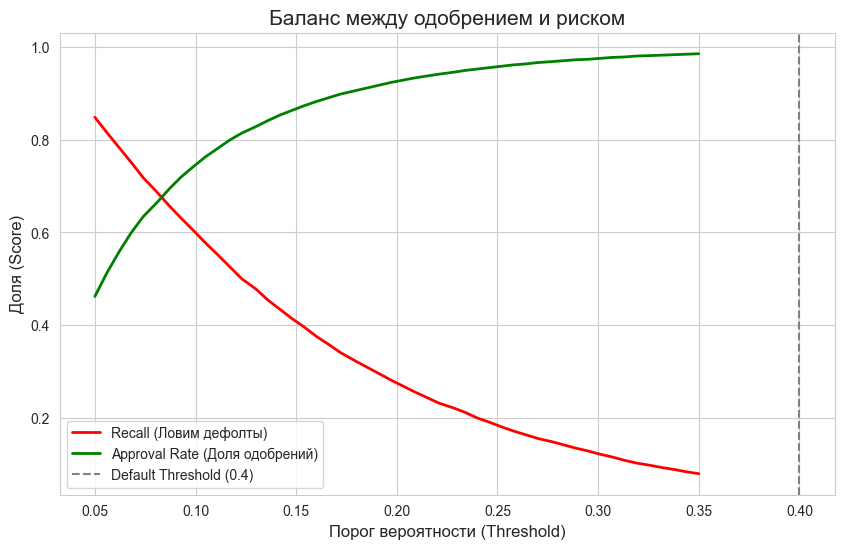

In [60]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')
plt.figure(figsize=(10, 6))

# recall (доля дефолтов)
plt.plot(threshold_df['threshold'], threshold_df['recall'], label='Recall (Ловим дефолты)', color='red', lw=2)

# approval (доля одобрений)
plt.plot(threshold_df['threshold'], threshold_df['approval'], label='Approval Rate (Доля одобрений)', color='green', lw=2)

plt.title('Баланс между одобрением и риском', fontsize=15)
plt.xlabel('Порог вероятности (Threshold)', fontsize=12)
plt.ylabel('Доля (Score)', fontsize=12)
plt.axvline(x=0.4, color='gray', linestyle='--', label='Default Threshold (0.4)') # Линия дефолтного порога

plt.legend(frameon=True)
plt.show()


#### Пересечение - доля пойманных дефолтников (Recall) равна доле одобренных клиентов (Approval).

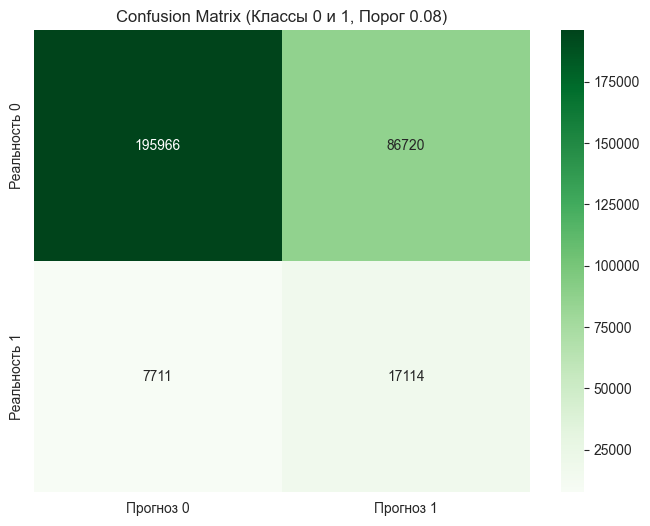

In [91]:
# confusion matrix для наглядности

threshold = 0.08 # берем приблизительное значение из предидущего графика
y_pred = (oof_pred >= threshold).astype(int)

cm = confusion_matrix(y_train, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', 
            xticklabels=['Прогноз 0', 'Прогноз 1'], 
            yticklabels=['Реальность 0', 'Реальность 1'])
plt.title(f'Confusion Matrix (Классы 0 и 1, Порог {threshold})')
plt.show()

#### Реальность 0 | Прогноз 0 (TN): Самые хорошие. Модель подтвердила отсутствие риска. Банк работает штатно.
#### Реальность 1 | Прогноз 0 (FN): Главный провал. Дефолт случился, но модель его не смогла предсказать.
#### Реальность 0 | Прогноз 1 (FP): Перестраховка. Дефолта нет, но модель «паникует». Это потерянные клиенты.
#### Реальность 1 | Прогноз 1 (TP): Успех. Модель четко идентифицировала угрозу и предотвратила потерю денег.

### После того как мы определили threshold и зависимость от них метрик recall / approval нам нужно превратить это в понятные бизнес метрики, которые позволят понять экономит ли наша модель деньги для банка или наоборот способствует потере прибыли.

## Business Optimization

### Установка гипотезы: при каком пороге threshold ожидаемая прибыль максимальна?

In [107]:
# вводим понятные бизнес метрики

time_interval = 12 # временной интервал в месяцах
loan = 100000 # средний размер тела кредита в рублях
rate = 0.20 # средняя процентная ставка по кредиту - 20% годовых
profit = loan * rate * (time_interval / 12) # прибыль с одного хорошего клиента

### Таким образом:
### 1. Одобрили кредит хорошему клиенту и он его вернул TN (true negative) → +profit (т.е. заработали на процентах)
### 2. Одобрили кредит дефолтному клиенту и он не вернул кредит FN (false negative) → −(loan + rate) (т.е. потеряли тело кредита. Потерянные проценты, как упущенную выгоду пока не считаем)
### 3. Отказали "хорошему" клиенту, который не собирался банкротится FP (false positiv) → 0 (упущенная выгода от неиспользования капитала. Но с учетом того, что движение капитала динамическое и эти деньги в след. раз будут выданы кредитом "хорошему" клиенту - считать их упущенной выгодной не будем.
### 4. Отказали дефолтному клиенту TP (true positive) → 0 (не потеряли размер кредита, это и есть экономия средств от работы нашей модели предсказаний)

## Считаем реальные денежные потоки:

In [108]:
# строим новую confusion_matrix с учетом бизнес-контекста

pd.options.display.float_format = '{:,.2f}'.format

# фиксируем набор threshold поинтов для теста
thresholds = np.linspace(0.05, 0.35, 50)
rows = []
N = len(y_train)

for t in thresholds:
    y_pred = (oof_pred >= t).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_train, y_pred).ravel()

    # применяем описанные выше бизнес-решения
    earned = tn * profit
    loss = fn * (loan + profit)
    net_profit = earned - loss

    recall = tp / (tp + fn) if (tp + fn) > 0 else 0 # ловим дефолты
    approval = (tn + fn) / N # доля одобрений

    rows.append({
        "Порог threshold": t,
        "TN (кредит хорошему клиенту)": tn,
        "FN (кредит дефолтному клиенту)": fn,
        "Заработали проценты от выдачи хорошему клиенту": earned,
        "Потеряли тело кредита + проценты от выдачи плохому клиенту": loss,
        "recall (сколько дефолтов в % поймали)": recall * 100,
        "approval (сколько клиентов в % одбрили)": approval * 100,
        "Чистая прибыль": net_profit
    })

business_df = pd.DataFrame(rows)
business_df.head() # для наглядности

,Порог threshold,TN (кредит хорошему клиенту),FN (кредит дефолтному клиенту),Заработали проценты от выдачи хорошему клиенту,Потеряли тело кредита + проценты от выдачи плохому клиенту,recall (сколько дефолтов в % поймали),approval (сколько клиентов в % одбрили),Чистая прибыль
0,0.05,138431,3761,"2,768,620,000.00","451,320,000.00",84.85,46.24,"2,317,300,000.00"
1,0.06,153063,4591,"3,061,260,000.00","550,920,000.00",81.51,51.27,"2,510,340,000.00"
2,0.06,166275,5395,"3,325,500,000.00","647,400,000.00",78.27,55.83,"2,678,100,000.00"
3,0.07,177860,6192,"3,557,200,000.00","743,040,000.00",75.06,59.85,"2,814,160,000.00"
4,0.07,187896,7003,"3,757,920,000.00","840,360,000.00",71.79,63.38,"2,917,560,000.00"


In [109]:
# находим оптимальный threshold (т.е. порог при котором наша модель выдает идеальные предсказания с т.з. бизнеса)

best_profit = business_df.sort_values("Чистая прибыль", ascending=False).iloc[0]
best_profit

Порог threshold                                                          0.13
TN (кредит хорошему клиенту)                                       241,735.00
FN (кредит дефолтному клиенту)                                      12,970.00
Заработали проценты от выдачи хорошему клиенту               4,834,700,000.00
Потеряли тело кредита + проценты от выдачи плохому клиенту   1,556,400,000.00
recall (сколько дефолтов в % поймали)                                   47.75
approval (сколько клиентов в % одбрили)                                 82.83
Чистая прибыль                                               3,278,300,000.00
Name: 13, dtype: float64

# Таким образом:
## При оптимальном пороге Threshold = 0.13
## Банк одобряет 83% клиентов
## Ловит 48% дефолтов
## И получает 3.27 млрд прибыли в год

# Однако, стоит учитывать что наши предсказания (хоть и справедливые) получены на train датасете (X_train) с заранее известным таргетом (y_train). Но в задаче у нас имеется test датасет (X_test) - это НОВЫЕ клиенты, которые придут завтра в банк чтобы получить кредит/отказ. Используя уже известный нам порог threshold заставим модель предсазать нам прибыль для наших будущих клиентов.

In [ ]:
# повторяем метрики

# best_threshold = 0.13 берем из расчетов выше
# X_test = preprocessing(df_application_test) берем из этапа preprocessing
# final_model берем из этапа final catboost model

# локальный препроцессинг x_test датасета перед предсказанием
def fill_cat_nan(df, cat_cols):
    df=df.copy()
    for col in cat_cols:
        df[col] = df[col].fillna('NA')
    return df

cat_cols = X_test.select_dtypes(include=['object', 'string']).columns.tolist()

X_test_final = fill_cat_nan(X_test.copy(), cat_cols)

# предсказания модели
X_test_proba = final_model.predict_proba(X_test_final)[:, 1]


In [ ]:
# применяем выбранный threshold

best_threshold = 0.13

X_test_pred = (X_test_proba >= best_threshold).astype(int)

In [117]:
# в test датасете у нас нет реального таргета, т.к. это симуляция будущих данных. Поэтому мы не можем построить матрицу распределений, но можем посчитать сколько наша модель одобрила клиентов и скольким отказала

approved = (X_test_pred == 0).sum() # одобрение
rejected = (X_test_pred == 1).sum() # отказ (не забываем, что 1 = дефолт в нашей задаче)

print(f'Одобрений: {approved}\nОтказов: {rejected}')


Одобрений: 40546
Отказов: 8198


### Как посчитать ожидаемую прибыль? 
#### На test (симуляция реальных данных) у нас нет заранее известного таргета. Значит мы не можем посчитать FN (одобрили кредит дефолтному клиенту и он его не вернул) напрямую, поэтому мы используем вероятности предсказания дефолта

#### Формула ожидаемой прибыли на одного клиента (если клиент одобрен):
#### $$E[profit] = (1 - p) \cdot profit - p \cdot (loan + profit)$$

#### Где:
#### * p — предсказанная моделью вероятность дефолта
#### * E[profit] - ожидаемая прибыль на одного клиента
#### * loan - средний размер тела кредита в рублях
#### * profit = (loan * rate * (time_interval / 12)) - прибыль с одного хорошего клиента


In [126]:
expected_profit = 0

for p in X_test_proba:
    if p < best_threshold: # одобренные клиенты
        expected_profit += (1-p) * profit - p * (loan + profit)

print(f"Суммарная ожидаемая прибыль: {expected_profit / 1_000_000:,.2f} млн") 

Суммарная ожидаемая прибыль: 514.61 млн


# При горизонте T (time_interval) месяцев ожидаемая прибыль на новых клиентах: 514.61 млн руб